In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from tqdm import tqdm
from pathlib import Path
import shutil
from datetime import datetime

In [3]:
ROOT = Path('../final')

In [4]:
dirs = sorted(ROOT.glob('*/*/*/*'))

In [5]:
f = next(dirs[0].glob('*temp_11_00um_20*'))

In [6]:
ds = xr.open_dataset(f)

In [7]:
f = '/ships19/cloud/scratch/cphillips/abi_scanline_time_luts/ABI-Time_Model_LUTS/ABI-Timeline05B_Mode 6A_20190612-183017.nc'

In [8]:
ds = xr.open_dataset(f, mask_and_scale=False, decode_times=False)

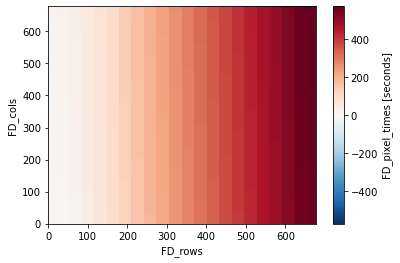

In [9]:
ds.FD_pixel_times[::8,::8].plot.imshow()

In [42]:
def get_latlons(fname, bounds):
    #this code is from here: https://github.com/makerportal/GOES-16-Fixed-Grid-Projection/blob/master/goes16_lat_lon_algorithm.py
    
    #Init file obj
    g16nc = Dataset(fname)
    
    #Get projection information
    proj_info = g16nc.variables['goes_imager_projection']
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis
    
    # read ints
    lat_rad_1d = g16nc.variables['x'][bounds[0]:bounds[1]]
    lon_rad_1d = g16nc.variables['y'][bounds[2]:bounds[3]]
    
    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin*np.pi)/180.0

    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)

    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    return lat, lon


def read_scan_line_time(fname, bounds):
    dataset = Dataset(fname)
    dt_start = dataset.time_coverage_start
    dt_start = datetime.datetime.strptime(dt_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    if dataset.timeline_id=='ABI Mode 6':
        schedule_path = '/ships19/cloud/scratch/cphillips/abi_scanline_time_luts/ABI-Time_Model_LUTS/ABI-Timeline05B_Mode 6A_20190612-183017.nc'
        timeline_dataset = Dataset(schedule_path)
        time_delta_secs = timeline_dataset['FD_pixel_times'][:].T
        time_delta_secs = time_delta_secs[bounds[0]:bounds[1], bounds[2]:bounds[3]]
    else:
        return
    
    dec_time_utc = dt_start.hour + dt_start.minute/60 + dt_start.second/60/60
    scan_line_time = dec_time_utc + time_delta_secs.T/60/60
    return scan_line_time

def read_all_channels(df, df_idx=0, bounds=[0,5424, 0, 5424], varnames=['latlon', '12', 'solar_zenith']):
    data = {}
    
    sample_fname = df[df.channel==12].iloc[df_idx]['fnames']
    
    # Loop through all requested variable names
    for varname in varnames:
        
        # Get latitude and longitudes if requested
        if 'latlon'==varname: data['lat'], data['lon'] = get_latlons(sample_fname, bounds)
            
        # Get the scan times of individual pixels
        elif 'scan_line_time'==varname: data[varname] = read_scan_line_time(sample_fname, bounds)
            
        elif 'solar_zenith'==varname: data[varname] = read_solar_zenith(sample_fname, data['lat'], data['lon'], bounds)
            
        #If integer value above 6, then assume channel requested and read the BT from the corresponding file
        elif int(varname)>=7:
            channel_num = int(varname)
            fname = df[df.channel==channel_num].iloc[df_idx]['fnames']
            data[varname] = read_bt(fname, bounds)
            
    # Do this loop so we aren't using masked arrays
    for key in list(data.keys()):
        data[key] = np.array(data[key], dtype='float32')
        
    return data